# Transfer Learning with TensorFlow: Fine-Tuning

In [144]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Get data

In [145]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [146]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [147]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [148]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [149]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [150]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[8.24553585e+00 7.24553585e+00 2.24553585e+00]
   [8.24553585e+00 8.24553585e+00 2.45535731e-01]
   [1.14598217e+01 1.14598217e+01 3.45982170e+00]
   ...
   [1.01151533e+01 1.14384623e+01 3.60011649e+00]
   [1.35449715e+01 1.40360432e+01 3.79050732e+00]
   [1.31578360e+01 1.36489077e+01 3.40337157e+00]]

  [[9.73660660e+00 8.73660660e+00 3.73660707e+00]
   [1.04205999e+01 1.04205999e+01 2.42059946e+00]
   [1.29508934e+01 1.29508934e+01 4.95089293e+00]
   ...
   [1.03125219e+01 1.13125219e+01 3.31252193e+00]
   [1.35267859e+01 1.48954277e+01 6.05262423e+00]
   [1.29062157e+01 1.56428223e+01 6.11603642e+00]]

  [[1.04553576e+01 9.00000000e+00 3.54464245e+00]
   [1.14553576e+01 1.07723217e+01 3.00000000e+00]
   [1.32764673e+01 1.25934305e+01 4.91868639e+00]
   ...
   [2.18225937e+01 2.16274605e+01 1.08411427e+01]
   [1.55793753e+01 1.69336720e+01 8.19545937e+00]
   [1.07578602e+01 1.43095722e+01 6.85421467e+00]]

  ...

  [[1.04227661e+02 7.18705215e+01 3.07079029e+01]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

In [151]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
# 2. Freeze the model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool of the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_0 = model_0.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=20,
    verbose=True,
    callbacks=[
        create_tensorboard_callback("05_tensorboard_logs", "10_percent_feature_extraction")
    ],
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: 05_tensorboard_logs/10_percent_feature_extraction/20210813-143006
Epoch 1/20


C:\ProgramData\Anaconda3\envs\general_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24/24 [==============================] - 12s 237ms/step - loss: 1.9140 - accuracy: 0.3960 - val_loss: 1.3055 - val_accuracy: 0.7352
Epoch 2/20
24/24 [==============================] - 3s 116ms/step - loss: 1.1599 - accuracy: 0.7213 - val_loss: 0.8873 - val_accuracy: 0.8092
Epoch 3/20
24/24 [==============================] - 3s 117ms/step - loss: 0.8588 - accuracy: 0.7947 - val_loss: 0.7350 - val_accuracy: 0.8339
Epoch 4/20
24/24 [==============================] - 3s 127ms/step - loss: 0.6910 - accuracy: 0.8413 - val_loss: 0.6415 - val_accuracy: 0.8438
Epoch 5/20
24/24 [==============================] - 3s 116ms/step - loss: 0.6040 - accuracy: 0.8480 - val_loss: 0.5827 - val_accuracy: 0.8536
Epoch 6/20
24/24 [==============================] - 3s 115ms/step - loss: 0.5199 - accuracy: 0.8787 - val_loss: 0.5544 - val_accuracy: 0.8651
Epoch 7/20
24/24 [==============================] - 3s 114ms/step - loss: 0.4679 - accuracy: 0.8973 - val_loss: 0.5113 - val_accuracy: 0.8668
Epoch 8/20
24/24

In [152]:
model_0.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.4438 - accuracy: 0.8564


[0.44381529092788696, 0.8564000129699707]

In [153]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_10
1 rescaling_9
2 normalization_9
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_

In [154]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, None, None, 3 0           input_10[0][0]                   
__________________________________________________________________________________________________
normalization_9 (Normalization) (None, None, None, 3 7           rescaling_9[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_9[0][0]            
_____________________________________________________________________________________

In [155]:
model_0.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


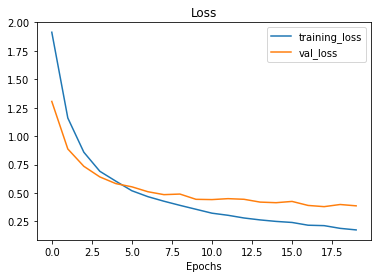

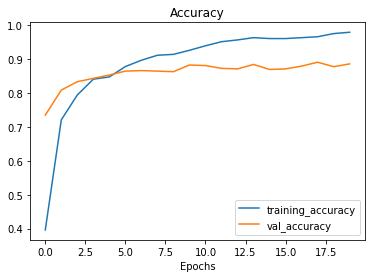

In [156]:
plot_loss_curves(history_0)

# Getting a feature vector from a trained model

Demonstrate the Global Average Pooling 2D layer

Similar shaped tensor (1,4,4,3) and pass it to GlobalAveragePooling2D

In [157]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_average_pooled_tensor.shape)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

(1, 3)
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [158]:
# Replicate the GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [159]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_max_pooled_tensor.shape)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

(1, 3)
2D global max pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



# Running a series of transfer learning experiments

1. `model_1` - use **feature extraction** *transfer learning* with **1%** of the training data with data augmentation
2. `model_2` - use **feature extraction** *transfer learning* with **10%** of the training with data augmentation
3. `model_3` - use **fine-tuning** *transfer learning* with **10%** of the training with data augmentation
4. `model_4` - use **fine-tuning** *transfer learning* with **100%** of the training with data augmentation

## Getting and preprocessing data for model_1

In [160]:
# Create training and test directories
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [161]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [162]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

In [163]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential(name="data_augmentation")
data_augmentation.add(preprocessing.RandomFlip("horizontal"))
data_augmentation.add(preprocessing.RandomZoom(0.2))
data_augmentation.add(preprocessing.RandomRotation(0.2))
data_augmentation.add(preprocessing.RandomHeight(0.2))
data_augmentation.add(preprocessing.RandomWidth(0.2))
# data_augmentation.add(preprocessing.Rescaling(1./255))


## Visualize data augmentation layer

1101478.jpg
(512, 512, 3)


Text(0.5, 1.0, 'Augmented random image from: ice_cream')

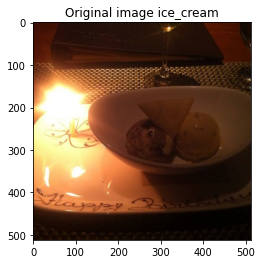

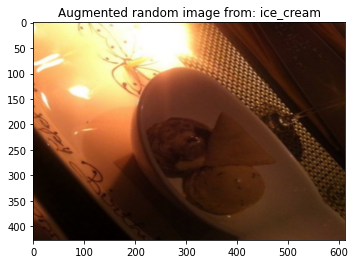

In [164]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
img = random.choice([x for x in os.listdir(target_dir)
               if os.path.isfile(os.path.join(target_dir, x))])
print(img)
img = mpimg.imread(target_dir +'/' +img)
plt.imshow(img, cmap=plt.cm.Blues)
plt.title(f"Original image {target_class}")
print(img.shape)
# Plot augmented image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
augmented_image = augmented_image/255
plt.figure()
plt.imshow(tf.squeeze(augmented_image))
plt.title(f"Augmented random image from: {target_class}")


#  model_1: Feature extraction transfer learning on 1% of the data with data augmentation

In [165]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                    epochs=20,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("05_tensorboard_logs", "1_percent_data_aug")])

Saving TensorBoard log files to: 05_tensorboard_logs/1_percent_data_aug/20210813-143124
Epoch 1/20
3/3 [==============================] - 11s 2s/step - loss: 2.4095 - accuracy: 0.1000 - val_loss: 2.2335 - val_accuracy: 0.1546
Epoch 2/20
3/3 [==============================] - 2s 798ms/step - loss: 2.1859 - accuracy: 0.3000 - val_loss: 2.1140 - val_accuracy: 0.2516
Epoch 3/20
3/3 [==============================] - 2s 902ms/step - loss: 2.0166 - accuracy: 0.3857 - val_loss: 2.0018 - val_accuracy: 0.3289
Epoch 4/20
3/3 [==============================] - 2s 785ms/step - loss: 1.8199 - accuracy: 0.4429 - val_loss: 1.9096 - val_accuracy: 0.4013
Epoch 5/20
3/3 [==============================] - 2s 901ms/step - loss: 1.6441 - accuracy: 0.5857 - val_loss: 1.8101 - val_accuracy: 0.4474
Epoch 6/20
3/3 [==============================] - 2s 862ms/step - loss: 1.5454 - accuracy: 0.6429 - val_loss: 1.7352 - val_accuracy: 0.4803
Epoch 7/20
3/3 [==============================] - 2s 744ms/step - loss: 1.

In [166]:
model_1.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [167]:
model_1.evaluate(test_data)

79/79 [==============================] - 5s 60ms/step - loss: 1.1587 - accuracy: 0.6780


[1.1586819887161255, 0.6779999732971191]

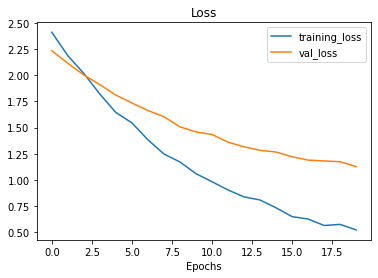

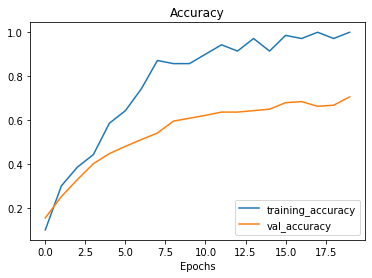

In [168]:
plot_loss_curves(history_1)

#  model_2: Feature extraction transfer learning on 10% of the data with data augmentation

In [169]:
# Create training and test directories
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [170]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [171]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [172]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                    epochs=20,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("05_tensorboard_logs", "10_percent_data_aug")])

Saving TensorBoard log files to: 05_tensorboard_logs/10_percent_data_aug/20210813-143219
Epoch 1/20
24/24 [==============================] - 16s 336ms/step - loss: 1.9837 - accuracy: 0.3507 - val_loss: 1.4868 - val_accuracy: 0.6530
Epoch 2/20
24/24 [==============================] - 5s 212ms/step - loss: 1.3353 - accuracy: 0.6933 - val_loss: 1.0317 - val_accuracy: 0.7796
Epoch 3/20
24/24 [==============================] - 5s 211ms/step - loss: 1.0358 - accuracy: 0.7667 - val_loss: 0.8418 - val_accuracy: 0.7944
Epoch 4/20
24/24 [==============================] - 5s 199ms/step - loss: 0.8726 - accuracy: 0.8027 - val_loss: 0.7426 - val_accuracy: 0.8109
Epoch 5/20
24/24 [==============================] - 5s 211ms/step - loss: 0.7795 - accuracy: 0.8000 - val_loss: 0.6814 - val_accuracy: 0.8026
Epoch 6/20
24/24 [==============================] - 5s 212ms/step - loss: 0.7142 - accuracy: 0.8080 - val_loss: 0.6466 - val_accuracy: 0.7993
Epoch 7/20
24/24 [==============================] - 5s 199

In [173]:
model_2.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model_0.save("models/10percent_no_aug.h5")
model_1.save("models/1percent_aug.h5")
model_2.save("models/10percent_aug.h5")